In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
from torch.nn.modules.batchnorm import BatchNorm2d

from torchvision import datasets

from torch.utils.data import DataLoader, random_split, SubsetRandomSampler

import torchvision
from torchvision.transforms import Compose, ToTensor, RandomRotation, RandomHorizontalFlip, ColorJitter, Normalize 

from torchsummary import summary


In [ ]:
def set_random_seeds():
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def test_model(model, test_data_loader, device):
    model.eval()
    test_num_correct = 0
    test_loss = 0.0
    total_test_points = 0

    for batch_num, (x, y) in enumerate(test_data_loader):
    
        #move data t device
        x, y = x.to(device), y.to(device)
    
        #make forward pass on val set
        y_pred = model(x)
        y_pred = y_pred.to(device)

        # number of correct predictions
        test_num_correct += (torch.argmax(y_pred, axis=1) == y).sum().item()
        total_test_points += len(y)
    
    print(f'Testing Accuracy = {test_num_correct/total_test_points}')

In [ ]:
def train_model(model, training_data_loader, validation_data_loader, epochs, loss_fn, optimiser, scheduler, device, model_name):

    #to track loss through the epoch 
    train_loss_per_epoch = []
    val_loss_per_epoch = []

    best_loss = float('inf')

    for epoch in range(epochs):

        print(f'################################### Epoch {epoch+1} ###################################')

        train_loss = 0
        validation_loss = 0

        train_examples = 0
        validation_examples = 0
        
        # Train
        model.train()
        train_num_correct = 0
        for batch_num, (x, y) in enumerate(training_data_loader):
            
            #zero grad
            optimiser.zero_grad()
            
            #move the data to the device 
            x, y = x.to(device), y.to(device)
            train_examples += len(y)

            #forward pass
            y_pred = model(x)
            y_pred = y_pred.to(device)

            train_num_correct += (torch.argmax(y_pred, axis=1) == y).sum().item()

            #calculate the loss
            loss = loss_fn(y_pred, y.long())
            train_loss += loss.item()

            #back propagation
            loss.backward()

            #update parameters using the optimiser        
            optimiser.step()

        train_loss_per_epoch.append(train_loss/train_examples)

        # Validate
        model.eval()
        val_num_correct = 0
        
        for batch_num, (x, y) in enumerate(validation_data_loader):
            
            #move data t device
            x, y = x.to(device), y.to(device)
            validation_examples += len(y)

            #make forward pass on val set
            y_pred = model(x)
            y_pred = y_pred.to(device)

            # number of correct predictions
            val_num_correct += (torch.argmax(y_pred, axis=1) == y).sum().item()
            
            #validation loss calculation
            val_loss_batch = loss_fn(y_pred, y.long())
            validation_loss += val_loss_batch.item()

            if val_loss_batch < best_loss:
                best_loss = val_loss_batch
                torch.save(model, model_name)

        val_loss_per_epoch.append(validation_loss/validation_examples)

        scheduler.step(validation_loss/validation_examples)

        print(f'Training Loss = {train_loss/train_examples}\
        \tTraining Accuracy = {train_num_correct/train_examples}\
        \tValidation_loss = {validation_loss/validation_examples}\
        \tValidation Accuracy = { val_num_correct/validation_examples}')

    return train_loss_per_epoch, val_loss_per_epoch

In [ ]:
def draw_loss_curves(train_loss_per_epoch, val_loss_per_epoch):
    plt.plot(train_loss_per_epoch, label='training loss')
    plt.plot(val_loss_per_epoch, label='validation loss')
    plt.title('Negative Log Loss')
    plt.ylabel('Log Loss')
    plt.xlabel('No. of Epochs')
    plt.legend()

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [ ]:
##splitting training data to train and validation set
set_random_seeds()
train_data, validation_data = random_split(training_data, [50000,10000])

In [ ]:
image, label = training_data[0]
print('Length of training set:' + str(len(training_data)))
print('Length of testing set:' + str(len(test_data)))
print(image.shape, label)
print(label)
print(training_data.classes)

Length of training set:60000
Length of testing set:10000
torch.Size([1, 28, 28]) 9
9
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
BATCH_SIZE = 512
NUM_CLASSES = len(training_data.classes)

in_features = 1 # grayscale channels

learning_rate = 1e-4
weight_decay = 5e-5
momentum = 0.9

In [ ]:
set_random_seeds()
train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE)
validation_dataloader = DataLoader(validation_data, batch_size = BATCH_SIZE)

#Model 1

## Creating a basic CNN model 

In [ ]:
from torch.nn.modules.batchnorm import BatchNorm2d
class MyCnnModel_1(nn.Module):
    def __init__(self, num_classes, batch_size):
        super(MyCnnModel_1, self).__init__()
        self.convolutional_sequence_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )

        self.flattening_layer = nn.Flatten()

        self.output_layer = nn.Sequential(
            nn.Linear(in_features=1568, out_features=num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.convolutional_sequence_1(x)
        #print('After Conv layer: {}'.format(out.shape))
        out = self.flattening_layer(out)
        #print('After Flattening layer: {}'.format(out.shape))
        out = self.output_layer(out)
        #print('After O/P layer: {}'.format(out.shape))
        return out

In [ ]:
set_random_seeds()
model = MyCnnModel_1(NUM_CLASSES, BATCH_SIZE)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimiser, patience=2, factor=0.8, verbose=True)

for parameter in model.parameters():
    print(parameter.data.shape)

torch.Size([8, 1, 3, 3])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([10, 1568])
torch.Size([10])


In [ ]:
num_epochs = 20
model_name = 'model_1'
train_loss, validation_loss = train_model(model, train_dataloader, validation_dataloader, num_epochs, criterion, optimiser, scheduler, device, model_name)

################################### Epoch 1 ###################################
Training Loss = 0.0040718541955947875        	Training Accuracy = 0.51788        	Validation_loss = 0.0038266146659851072        	Validation Accuracy = 0.6354
################################### Epoch 2 ###################################
Training Loss = 0.003592291045188904        	Training Accuracy = 0.70878        	Validation_loss = 0.003558080017566681        	Validation Accuracy = 0.7491
################################### Epoch 3 ###################################
Training Loss = 0.0034284815764427184        	Training Accuracy = 0.76726        	Validation_loss = 0.003468827283382416        	Validation Accuracy = 0.7701
################################### Epoch 4 ###################################
Training Loss = 0.0033638518285751345        	Training Accuracy = 0.78638        	Validation_loss = 0.003409080171585083        	Validation Accuracy = 0.7991
################################### Epoch 5 ####

In [ ]:
model = torch.load(model_name)
test_model(model, test_dataloader, device)

Testing Accuracy = 0.868


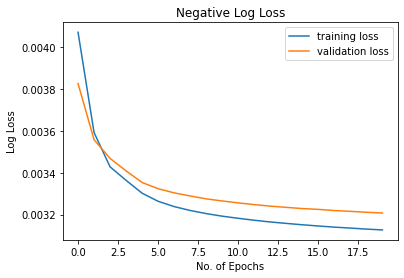

In [ ]:
draw_loss_curves(train_loss, validation_loss)

#Model 2

## Using Image Transforms In Dataset

A basic Convolutional Network with 1 convolutional layer and 1 fully connected layer has an accuracy of 86.8%. We will consider that our baseline model. 

Before changing the wights initialisation strategy or optimiser or network, we shall play around with few other things. 
Changing the dataset using some basic transforms which are common to use on an image dataset. hopefully this increases the variety in data and reduces overfitting, if thats whats happening in the model. 

In [ ]:
!rm -rf data/

In [ ]:
training_data_with_transforms= datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([
        RandomRotation(20), 
        RandomHorizontalFlip(0.5), 
        ColorJitter(0.5), 
        ToTensor(),
        Normalize(mean = (0.485),
                  std= (0.229)) 
    ])
)

test_data_with_transforms = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=Compose([
        ToTensor(),
        Normalize(mean = (0.485),
                  std= (0.229))
    ])
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
set_random_seeds()
train_data_with_transforms, validation_data_with_transforms = random_split(training_data_with_transforms, [50000,10000])
num_workers = 8 if device == 'cuda' else 0

set_random_seeds()
train_data_with_transforms_data_loader = DataLoader(train_data_with_transforms, num_workers = num_workers, batch_size = BATCH_SIZE, shuffle=True)
test_data_with_transforms_data_loader = DataLoader(test_data_with_transforms, num_workers = num_workers, batch_size = BATCH_SIZE)
validation_data_with_transforms_data_loader = DataLoader(validation_data_with_transforms, num_workers = num_workers, batch_size = BATCH_SIZE)

In [ ]:
set_random_seeds()
model = MyCnnModel_1(NUM_CLASSES, BATCH_SIZE)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimiser, patience=2, factor=0.8, verbose=True)

In [ ]:
num_epochs = 20
model_name = 'model_2'
train_loss, validation_loss = train_model(model, train_data_with_transforms_data_loader, validation_data_with_transforms_data_loader, num_epochs, criterion, optimiser, scheduler, device, model_name)

################################### Epoch 1 ###################################
Training Loss = 0.004209715433120728        	Training Accuracy = 0.40414        	Validation_loss = 0.004015577864646912        	Validation Accuracy = 0.596
################################### Epoch 2 ###################################
Training Loss = 0.0037804056072235108        	Training Accuracy = 0.65368        	Validation_loss = 0.0037648385763168336        	Validation Accuracy = 0.6779
################################### Epoch 3 ###################################
Training Loss = 0.003619829423427582        	Training Accuracy = 0.69776        	Validation_loss = 0.003654056477546692        	Validation Accuracy = 0.7056
################################### Epoch 4 ###################################
Training Loss = 0.0035414355421066286        	Training Accuracy = 0.71846        	Validation_loss = 0.003586379849910736        	Validation Accuracy = 0.7234
################################### Epoch 5 ######

In [ ]:
model = torch.load(model_name)
test_model(model, test_data_with_transforms_data_loader, device)

Testing Accuracy = 0.7915


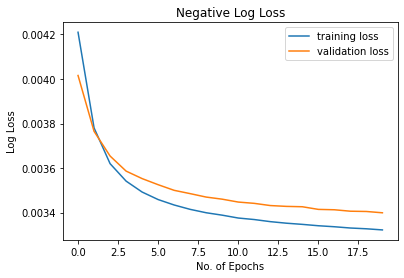

In [ ]:
draw_loss_curves(train_loss, validation_loss)

Clearly this model does not pass our baseline model. 
Maybe a simple model with just 1 convolutional layer and 1 fcn is not powerful enough to take advantage of a bigger dataset. So lets try improving our network depth. 

#Model 3

In [ ]:
class MyCnnModel_2(nn.Module):
    def __init__(self, num_classes, batch_size, fully_connected_layer_activation_function):
        super().__init__()
        self.convolutional_sequence_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),#neurons=8*3*3
            nn.BatchNorm2d(8),
            nn.ReLU()
        )

        self.convolutional_sequence_2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),#neurons=16*3*3
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.convolutional_sequence_3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),#neurons=32*3*3
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.convolutional_sequence_4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )

        self.flattening_layer = nn.Flatten()

        self.fully_connected_sequence_1 = nn.Sequential(
            nn.Linear(in_features=12544, out_features=256),
            nn.Dropout(p=0.2),
            fully_connected_layer_activation_function
        )

        self.fully_connected_sequence_2 = nn.Sequential(
            nn.Linear(in_features=256, out_features=128),
            nn.Dropout(p=0.2),
            fully_connected_layer_activation_function
        )

        self.fully_connected_sequence_3 = nn.Sequential(
            nn.Linear(in_features=128, out_features=64),
            nn.Dropout(p=0.2),
            fully_connected_layer_activation_function
        )

        self.output_layer = nn.Sequential(
            nn.Linear(in_features=64, out_features=num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.convolutional_sequence_1(x)
        #print('After 1st Con layer: {}'.format(out.shape))
        out = self.convolutional_sequence_2(out)
        #print('After 2nd Con layer: {}'.format(out.shape))
        out = self.convolutional_sequence_3(out)
        #print('After 3rd Con layer: {}'.format(out.shape))
        out = self.convolutional_sequence_4(out)
        #print('After 4rd Con layer: {}'.format(out.shape))
        out = self.flattening_layer(out)
        #print('After Flattening layer: {}'.format(out.shape))
        out = self.fully_connected_sequence_1(out)
        print('After 1st FC layer: {}'.format(out.shape))
        out = self.fully_connected_sequence_2(out)
        print('After 2nd FC layer: {}'.format(out.shape))
        out = self.fully_connected_sequence_3(out)
        print('After 3nd FC layer: {}'.format(out.shape))
        out = self.output_layer(out)
        print('After O/P layer: {}'.format(out.shape))
        return out

In [ ]:
set_random_seeds()
model = MyCnnModel_2(NUM_CLASSES, BATCH_SIZE, nn.ReLU())
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimiser, patience=2, factor=0.8, verbose=True)

In [ ]:
num_epochs = 20
model_name = 'model_3'
train_loss_for_transformed_data, validation_loss_for_transformed_data = train_model(model, train_data_with_transforms_data_loader, validation_data_with_transforms_data_loader, num_epochs, criterion, optimiser, scheduler, device, model_name)

################################### Epoch 1 ###################################
Training Loss = 0.003991230509281158        	Training Accuracy = 0.45124        	Validation_loss = 0.0037644456028938294        	Validation Accuracy = 0.581
################################### Epoch 2 ###################################
Training Loss = 0.0036080483961105345        	Training Accuracy = 0.63132        	Validation_loss = 0.003566801381111145        	Validation Accuracy = 0.6809
################################### Epoch 3 ###################################
Training Loss = 0.003497955827713013        	Training Accuracy = 0.68262        	Validation_loss = 0.00354263037443161        	Validation Accuracy = 0.6904
################################### Epoch 4 ###################################
Training Loss = 0.003469796414375305        	Training Accuracy = 0.69542        	Validation_loss = 0.0035188511967658995        	Validation Accuracy = 0.7017
################################### Epoch 5 #######

In [ ]:
model = torch.load(model_name)
test_model(model, test_data_with_transforms_data_loader, device)

Testing Accuracy = 0.8376


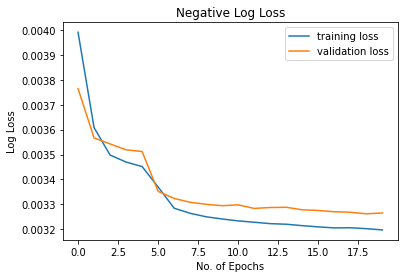

In [ ]:
draw_loss_curves(train_loss_for_transformed_data, validation_loss_for_transformed_data)

#Model 4

## Changing relu to leaky relu in the fully connected layers

We will now change the ReLU activation function in the fully connected layers to Leaky ReLU and see the changes on loss and accuracy of the previous model 

In [ ]:
set_random_seeds()
model = MyCnnModel_2(NUM_CLASSES, BATCH_SIZE, nn.LeakyReLU())
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimiser, patience=2, factor=0.8, verbose=True)

In [ ]:
num_epochs = 20
model_name = 'model_4'
train_loss_for_transformed_data, validation_loss_for_transformed_data = train_model(model, train_data_with_transforms_data_loader, validation_data_with_transforms_data_loader, num_epochs, criterion, optimiser, scheduler, device, model_name)

################################### Epoch 1 ###################################
Training Loss = 0.003981398324966431        	Training Accuracy = 0.45632        	Validation_loss = 0.0037067737460136415        	Validation Accuracy = 0.6159
################################### Epoch 2 ###################################
Training Loss = 0.003563108060359955        	Training Accuracy = 0.65448        	Validation_loss = 0.0035595759987831115        	Validation Accuracy = 0.6833
################################### Epoch 3 ###################################
Training Loss = 0.00348948760509491        	Training Accuracy = 0.68572        	Validation_loss = 0.003537599813938141        	Validation Accuracy = 0.6939
################################### Epoch 4 ###################################
Training Loss = 0.0034637071657180785        	Training Accuracy = 0.69736        	Validation_loss = 0.003515952515602112        	Validation Accuracy = 0.704
################################### Epoch 5 #######

In [ ]:
model = torch.load(model_name)
test_model(model, test_data_with_transforms_data_loader, device)

Testing Accuracy = 0.8637


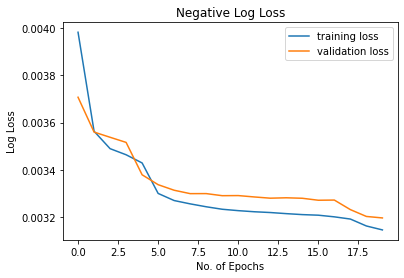

In [ ]:
draw_loss_curves(train_loss_for_transformed_data, validation_loss_for_transformed_data)

#Model 5

## We can now try changing the weights initialisation strategy

In [ ]:
def initialize_weights(m):

  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_normal_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)

  elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)

  elif isinstance(m, nn.Linear):
      nn.init.kaiming_normal_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

In [ ]:
set_random_seeds()
kaiming_weight_model = MyCnnModel_2(NUM_CLASSES, BATCH_SIZE, nn.LeakyReLU())
kaiming_weight_model.apply(initialize_weights)
kaiming_weight_model = kaiming_weight_model.to(device)

criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(kaiming_weight_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimiser, patience=2, factor=0.8, verbose=True)

In [ ]:
num_epochs = 20
model_name = 'model_5'
train_loss_for_transformed_data, validation_loss_for_transformed_data = train_model(kaiming_weight_model, train_data_with_transforms_data_loader, validation_data_with_transforms_data_loader, num_epochs, criterion, optimiser, scheduler, device, model_name)

################################### Epoch 1 ###################################
Training Loss = 0.0038549502563476564        	Training Accuracy = 0.49798        	Validation_loss = 0.0036098105549812317        	Validation Accuracy = 0.6624
################################### Epoch 2 ###################################
Training Loss = 0.0035395225834846497        	Training Accuracy = 0.66042        	Validation_loss = 0.0034008931279182436        	Validation Accuracy = 0.7649
################################### Epoch 3 ###################################
Training Loss = 0.003373997805118561        	Training Accuracy = 0.74604        	Validation_loss = 0.0033458871960639954        	Validation Accuracy = 0.7885
################################### Epoch 4 ###################################
Training Loss = 0.0033253721070289613        	Training Accuracy = 0.76866        	Validation_loss = 0.003321752893924713        	Validation Accuracy = 0.8004
################################### Epoch 5 ##

In [ ]:
model = torch.load(model_name)
test_model(model, test_data_with_transforms_data_loader, device)

Testing Accuracy = 0.8562


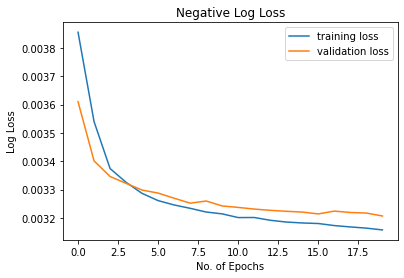

In [ ]:
draw_loss_curves(train_loss_for_transformed_data, validation_loss_for_transformed_data)

# Model 6

## Trying to stratify the dataset with a more even spread of labels in training and validation set

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

targets = training_data_with_transforms.targets.tolist()

set_random_seeds()
train_idx, valid_idx= train_test_split(
    np.arange(len(targets)),
    test_size=1/6,
    shuffle=True,
    stratify=targets)

train_sampler = SubsetRandomSampler(train_idx)
valididation_sampler = SubsetRandomSampler(valid_idx)

num_workers = 8 if device == 'cuda' else 0

train_data_with_transforms_data_loader = DataLoader(training_data_with_transforms, num_workers = num_workers, batch_size = BATCH_SIZE, sampler=train_sampler)
test_data_with_transforms_data_loader = DataLoader(test_data_with_transforms, num_workers = num_workers, batch_size = BATCH_SIZE)
validation_data_with_transforms_data_loader = DataLoader(training_data_with_transforms, num_workers = num_workers, batch_size = BATCH_SIZE, sampler=valididation_sampler)

In [ ]:
set_random_seeds()
kaiming_weight_model = MyCnnModel_2(NUM_CLASSES, BATCH_SIZE, nn.LeakyReLU())
kaiming_weight_model.apply(initialize_weights)
kaiming_weight_model = kaiming_weight_model.to(device)

criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(kaiming_weight_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimiser, patience=2, factor=0.8, verbose=True)

In [ ]:
num_epochs = 20
model_name = 'model_6'
train_loss_for_transformed_data, validation_loss_for_transformed_data = train_model(kaiming_weight_model, train_data_with_transforms_data_loader, validation_data_with_transforms_data_loader, num_epochs, criterion, optimiser, scheduler, device, model_name)


################################### Epoch 1 ###################################
Training Loss = 0.0038571357440948485        	Training Accuracy = 0.49742        	Validation_loss = 0.003600745725631714        	Validation Accuracy = 0.6627
################################### Epoch 2 ###################################
Training Loss = 0.003537699625492096        	Training Accuracy = 0.66146        	Validation_loss = 0.0035116105556488035        	Validation Accuracy = 0.7008
################################### Epoch 3 ###################################
Training Loss = 0.0033900826287269594        	Training Accuracy = 0.73772        	Validation_loss = 0.003358500349521637        	Validation Accuracy = 0.7839
################################### Epoch 4 ###################################
Training Loss = 0.0033192975759506224        	Training Accuracy = 0.7724        	Validation_loss = 0.0033273802399635317        	Validation Accuracy = 0.7987
################################### Epoch 5 ####

In [ ]:
model = torch.load(model_name)
test_model(model, test_data_with_transforms_data_loader, device)

Testing Accuracy = 0.8533


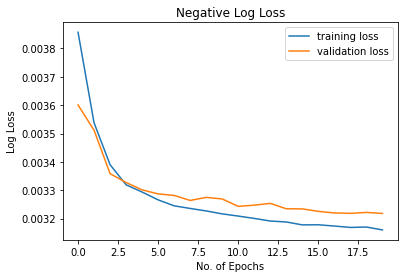

In [ ]:
draw_loss_curves(train_loss_for_transformed_data, validation_loss_for_transformed_data)

# Model 7

## Increasing the channels to increase feature extractions

To increase the number of features extracted, we just remove the max pooling layer that reduced the number of features by 75%

In [ ]:
class MyCnnModel_3(nn.Module):
    def __init__(self, num_classes, batch_size, fully_connected_layer_activation_function):
        super().__init__()
        self.convolutional_sequence_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )

        self.convolutional_sequence_2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.convolutional_sequence_3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.convolutional_sequence_4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )

        self.flattening_layer = nn.Flatten()

        self.fully_connected_sequence_1 = nn.Sequential(
            nn.Linear(in_features=12544, out_features=256),
            nn.Dropout(p=0.2),
            fully_connected_layer_activation_function
        )

        self.fully_connected_sequence_2 = nn.Sequential(
            nn.Linear(in_features=256, out_features=128),
            nn.Dropout(p=0.2),
            fully_connected_layer_activation_function
        )

        self.fully_connected_sequence_3 = nn.Sequential(
            nn.Linear(in_features=128, out_features=64),
            nn.Dropout(p=0.2),
            fully_connected_layer_activation_function
        )

        self.output_layer = nn.Sequential(
            nn.Linear(in_features=64, out_features=num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.convolutional_sequence_1(x)
        #print('After 1st Con layer: {}'.format(out.shape))
        out = self.convolutional_sequence_2(out)
        #print('After 2nd Con layer: {}'.format(out.shape))
        out = self.convolutional_sequence_3(out)
        #print('After 3rd Con layer: {}'.format(out.shape))
        out = self.convolutional_sequence_4(out)
        #print('After 4rd Con layer: {}'.format(out.shape))
        out = self.flattening_layer(out)
        #print('After Flattening layer: {}'.format(out.shape))
        out = self.fully_connected_sequence_1(out)
        #print('After 1st FC layer: {}'.format(out.shape))
        out = self.fully_connected_sequence_2(out)
        #print('After 2nd FC layer: {}'.format(out.shape))
        out = self.fully_connected_sequence_3(out)
        #print('After 3nd FC layer: {}'.format(out.shape))
        out = self.output_layer(out)
        #print('After O/P layer: {}'.format(out.shape))
        return out

In [ ]:
set_random_seeds()
model = MyCnnModel_3(NUM_CLASSES, BATCH_SIZE, nn.LeakyReLU())
model.apply(initialize_weights)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimiser, patience=2, factor=0.8, verbose=True)

In [ ]:
num_epochs = 20
model_name = 'model_7'
train_loss_for_transformed_data, validation_loss_for_transformed_data = train_model(model, train_data_with_transforms_data_loader, validation_data_with_transforms_data_loader, num_epochs, criterion, optimiser, scheduler, device, model_name)


################################### Epoch 1 ###################################
Training Loss = 0.0038612857270240784        	Training Accuracy = 0.49538        	Validation_loss = 0.0036024799466133116        	Validation Accuracy = 0.663
################################### Epoch 2 ###################################
Training Loss = 0.003536230754852295        	Training Accuracy = 0.6629        	Validation_loss = 0.0035131271958351133        	Validation Accuracy = 0.7041
################################### Epoch 3 ###################################
Training Loss = 0.0034699511623382568        	Training Accuracy = 0.69394        	Validation_loss = 0.0034768664360046385        	Validation Accuracy = 0.7181
################################### Epoch 4 ###################################
Training Loss = 0.0033488360595703127        	Training Accuracy = 0.75842        	Validation_loss = 0.0033382676124572752        	Validation Accuracy = 0.7923
################################### Epoch 5 ###

In [ ]:
model = torch.load(model_name)
test_model(model, test_data_with_transforms_data_loader, device)

Testing Accuracy = 0.8526


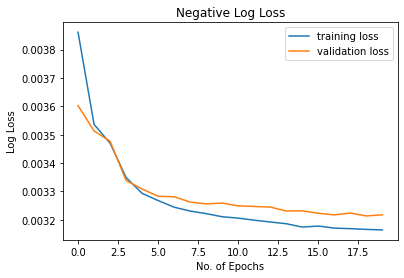

In [ ]:
draw_loss_curves(train_loss_for_transformed_data, validation_loss_for_transformed_data)

In [ ]:
best_model = torch.load('model_4')
best_model.parameters

<bound method Module.parameters of MyCnnModel_2(
  (convolutional_sequence_1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convolutional_sequence_2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convolutional_sequence_3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convolutional_sequence_4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), p

In [ ]:
summary(model, input_size= (1,28,28))

After 1st FC layer: torch.Size([2, 256])
After 2nd FC layer: torch.Size([2, 128])
After 3nd FC layer: torch.Size([2, 64])
After O/P layer: torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           1,168
       BatchNorm2d-5           [-1, 16, 28, 28]              32
              ReLU-6           [-1, 16, 28, 28]               0
            Conv2d-7           [-1, 32, 28, 28]           4,640
       BatchNorm2d-8           [-1, 32, 28, 28]              64
              ReLU-9           [-1, 32, 28, 28]               0
           Conv2d-10           [-1, 64, 28, 28]          18,496
      BatchNorm2d-11           [-1, 64, 28, 28]             128
        